# Fundamentals of Robot Control
## Assignment - 1
written by : Jameel Ahmed Syed
email : j.syed@innopolis.university

# Problem №1: Regulation of magnetic tape system via pole-placement

<hr>

The differential equations of the tape recorder are given as :
$$
\begin{array}{c}
J \ddot{\theta}_{1}=-T_{e} r+K_{m} i_{1} \\
J \ddot{\theta}_{2}=-T_{e} r+K_{m} i_{2} \\
T_{e}=k\left(x_{2}-x_{1}\right)+b\left(\dot{x}_{2}-\dot{x}_{1}\right) \\
x_{3}=\frac{x_{1}+x_{2}}{2}
\end{array}
$$

The goal is to design feedback controller, $\mathbf{u}=-\mathbf{K} \mathbf{x}$ to regulate to constant position of magnetic tape $x_{3}=x_{d}[\mathrm{~mm}]$ over the read head of a magnetic tape drive while maintaining a specified tension $T_{e}=10$, namely:


##### <u>Contents:
1. Import All the Necessary Libraries
2. Rewrite the system in linear state space form
3. Stability and Controllability
    - Check stability before pole Placement.
    - Check Controllability before pole Placement.
4. Check controllability just with one actuator (u=i1, i2=0)
5. Minimal number of control channels for this system to be controllable and stabilizable
6. Place poles of closed loop system and find the gain-matrix
    such that $\hspace{1cm} \begin{equation} T_e = 10 \hspace{1cm} and \hspace{1cm} x_3 = x_d = \frac{\left(x_1+x_2\right)}{2} \end{equation}$
    - Check stability after pole Placement.
7. Simulate the Response of Actuator 1 and 2
8. Tension $T_e$ in the tape is maintained at 10 N
9. The distance is maintained such that $x_3=x_d=\frac{x_1+x_2}{2}$

<hr>

### 1. Import All the Necessary Libraries

In [99]:
import numpy as np
from numpy.linalg import eig
from numpy import real
import matplotlib.pyplot as plt
from scipy.signal import place_poles
from scipy.integrate import odeint

<hr>

### 2. Rewrite the system in linear state space form


Choosing the state to be $\mathbf{x} = [x_1, \dot{x_2}, x_2, \dot{x_2}]^T$One may rewrite this dynamics in the state-space form as:
\begin{equation}
\mathbf{\dot{x}} =
\begin{bmatrix}
\dot{x_1} \\
\ddot{x_1} \\
\dot{x_2} \\
\ddot{x_2}
\end{bmatrix}
=
\begin{bmatrix}
0 & 1 & 0 & 0 \\
\frac{k*r^2}{J} & \frac{b*r^2}{J} & -\frac{k*r^2}{J} & -\frac{b*r^2}{J} \\
0 & 0 & 0 & 1\\
\frac{k*r^2}{J} & \frac{b*r^2}{J} & -\frac{k*r^2}{J} & -\frac{b*r^2}{J}
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 \\
\frac{r*Km}{J} & 0 \\
0 & 0 \\
0 & \frac{r*Km}{J} \\
\end{bmatrix}
\begin{bmatrix}
u_1 \\
u_2
\end{bmatrix}
\end{equation}

where:

- $\theta_{1}, \theta_{2}, [\mathrm{rad}]$ angular position of motor capstan assembly

- $x_{1}, x_{2}, [\mathrm{~mm}]$ position of tape at capstan assembly

- $i_{1}, i_{2}, [\mathrm{~A}]$ current into drive motors 1 and 2

- $x_{3}, [\mathrm{~mm}]$ position of tape over read head

- $T_{e}, [\mathrm{~N}]$ tension in tape

- $J=0.006375, \left[\mathrm{~kg} \mathrm{~m}{ }^{2}\right]$ motor and capstan inertia

- $K_{m}=0.544, [\mathrm{Nm} / \mathrm{A}]$ motor torque constant

- $k=2113, [\mathrm{~N} / \mathrm{m}]$ tape spring constant

- $b=3.75, [\mathrm{Ns} / \mathrm{m}]$ tape damping constant

- $r=0.05, [\mathrm{~m}]$ capstan radius

In [100]:
J = 0.006375    # [kg m^2] motor and capstan inertia
Km = 0.544      # [Nm/A] motor torque constant
k = 2113        # [N/m] tape spring constant
b = 3.75        # [Ns/m] tape damping constant
r = 0.05        # [m] capstan radius
i1 = 1          # [A] current into motor 1
i2 = 1          # [A] current into motor 2

In [101]:
temp1 = (k*(r**2)/J)
temp2 = (b*(r**2)/J)

A = np.array([[0, 1, 0, 0],
              [temp1, temp2, -temp1, -temp2],
              [0, 0, 0, 1],
              [temp1, temp2, -temp1, -temp2]])

B = np.array([[0, 0],
              [r*Km/J, 0],
              [0, 0],
              [0, r*Km/J]])

u = np.array([[i1],
              [i2]])

In [102]:
print("A matrix = \n", A)

A matrix = 
 [[   0.            1.            0.            0.        ]
 [ 828.62745098    1.47058824 -828.62745098   -1.47058824]
 [   0.            0.            0.            1.        ]
 [ 828.62745098    1.47058824 -828.62745098   -1.47058824]]


In [103]:
print("B matrix = \n", B)

B matrix = 
 [[0.         0.        ]
 [4.26666667 0.        ]
 [0.         0.        ]
 [0.         4.26666667]]


<hr>

## 3. Stability and Controllablilty

- Check Stability before pole placement

In [104]:
def check_stability(a):
    lambdas = np.linalg.eigvals(a)
    print("Eigen values of matrix are : ", real(lambdas))

    if np.all(real(lambdas) < 0):
        print("System is stable")
    else:
        print("System is unstable")

In [105]:
check_stability(A)

Eigen values of matrix are :  [-0.00269385 -0.00269385  0.00269385  0.00269385]
System is unstable


- Check Controllability before pole placement

In [106]:
def pbh(A, B):
    lambdas, v = np.linalg.eig(A)
    n = np.shape(A)[0]
    ranks = n*[0]
    test = 'controllable'
    for i in range(n):
        A_e = A - lambdas[i]*np.eye(n)
        M = np.hstack((A_e, B))
        ranks[i] = np.linalg.matrix_rank(M)
        if ranks[i] != n:
            test = 'uncontrollable'
    return lambdas, ranks, test

In [107]:
eigs, ranks, test = pbh(A, B)
print(f'Eigen values of A matrix:\n{eigs}\n\nRanks of the PBH matrices: {ranks},\nsystem is {test}' )

Eigen values of A matrix:
[-0.00269385+0.00269385j -0.00269385-0.00269385j  0.00269385+0.00269386j
  0.00269385-0.00269386j]

Ranks of the PBH matrices: [4, 4, 4, 4],
system is controllable


<hr>

## 5. Minimal Number of Control Channels

Check controllability just with one actuator $\left(u=i_{1}, i_{2}=0\right)$

In [108]:
# Making the u2 term as zero in the B_min matrix

B_min = np.array([[0, 0],
                 [r*Km/J, 0],
                 [0, 0],
                 [0, 0]])

i1 = 1
i2 = 0

u = np.array([[i1],
              [i2]])


print(B_min)

[[0.         0.        ]
 [4.26666667 0.        ]
 [0.         0.        ]
 [0.         0.        ]]


In [109]:
def pbh_with_stability(A, B):
    lambdas, v = np.linalg.eig(A)
    n = np.shape(A)[0]
    ranks = n*[0]
    uncontrol_eigs = []
    test = 'controllable'
    for i in range(n):
        A_e = A - lambdas[i]*np.eye(n)
        M = np.hstack((A_e, B))
        ranks[i] = np.linalg.matrix_rank(M)
        if ranks[i] != n:
            uncontrol_eigs.append(lambdas[i])

    if uncontrol_eigs:
        if np.all(np.array(uncontrol_eigs) < 0):
            print(uncontrol_eigs)
            test = 'uncontrollable but stabilizable'

        else:
            test = 'uncontrollable'

    return lambdas, ranks, test

In [110]:
eigs, ranks, test = pbh_with_stability(A, B_min)
print(f'Eigen values of A matrix:\n{eigs}\n\nRanks of the PBH matrices: {ranks},\nsystem is {test}' )

Eigen values of A matrix:
[-0.00269385+0.00269385j -0.00269385-0.00269385j  0.00269385+0.00269386j
  0.00269385-0.00269386j]

Ranks of the PBH matrices: [4, 4, 4, 4],
system is controllable


##### As we see above that the system is controllable even after disabling one Actuator because our system doesn't know two things; firstly, it doesnt know that the system is not rigid, it see the system as rigid. Secondly, it also doesnt know the direction of the motor movement. That is why the system is controllable

<hr>

## 6. Place poles of closed loop system and find the gain-matrix

such that $\hspace{1cm} \begin{equation} T_e = 10 \hspace{1cm} and \hspace{1cm} x_3 = x_d = \frac{\left(x_1+x_2\right)}{2} \end{equation}$

In [111]:
P = np.array([-10.0+0j, -5.0+0j, -10.0-0j, -5.0-0j])    # New poles, tested to be close to the desired values
K = place_poles(A, B, P).gain_matrix        # New Gain Matrix K according to the new Poles
Ac = A - B@K                                # New Ac matrix with new Poles
eig_vals, q = np.linalg.eig(Ac)             # Eigen values of Ac Matrix
print("Eigen Values of Ac matrix : ", real(eig_vals), end="\n\n")
print("Gain-matrix K : \n", K, end="\n\n")
print("Shape of K matrix : ", K.shape, end="\n\n")

Eigen Values of Ac matrix :  [ -5. -10. -10.  -5.]

Gain-matrix K : 
 [[ 205.92830882    3.86029412 -194.20955882   -0.34466912]
 [ 194.20955882    0.34466912 -182.49080882    3.17095588]]

Shape of K matrix :  (2, 4)



- Check stability after pole placement

In [112]:
check_stability(Ac)

Eigen values of matrix are :  [ -5. -10. -10.  -5.]
System is stable


<hr>

## 7. Simulate the Response of Actuator 1 and 2

Keeping $\dot{x_1} = 0, \dot{x_2} = 0, T_e = 10$

By solving $T_{e}=k\left(x_{2}-x_{1}\right)+b\left(\dot{x}_{2}-\dot{x}_{1}\right) \hspace{1cm}and\hspace{1cm} x_d = x_{3}=\frac{x_{1}+x_{2}}{2}$

We get $x^d_1 = x_d - \frac{5}{k} \hspace{1cm} and \hspace{1cm} x^d_2 = x_d + \frac{5}{k}$


In [113]:
def system_ode(x, t, A, B, K, x_d):
    k_dc_inverse = 2    # Inverse of dc gain
    xe = k_dc_inverse*x_d - x
    u = np.dot(K, x_d)
    dx = np.dot(A,x) + np.dot(B, u)
    return dx

tf = 5                      # Final time
N = int(100)                # Numbers of points in time span
t = np.linspace(0, tf, N)   # Create time span

# Set initial state
x0 = np.array([0.1, 0.1, 0.1, 0.1])

# Set Desired value
xd = 100

# Set Desired state
x_d = np.array([xd-(5/k), 0, (5/k)+xd, 0])

In [114]:
x_sol = odeint(system_ode, x0, t, args=(Ac, B, K, x_d,))
x_1, dx_1, x_2, dx_2 = x_sol[:,0], x_sol[:,1], x_sol[:,2], x_sol[:,3]

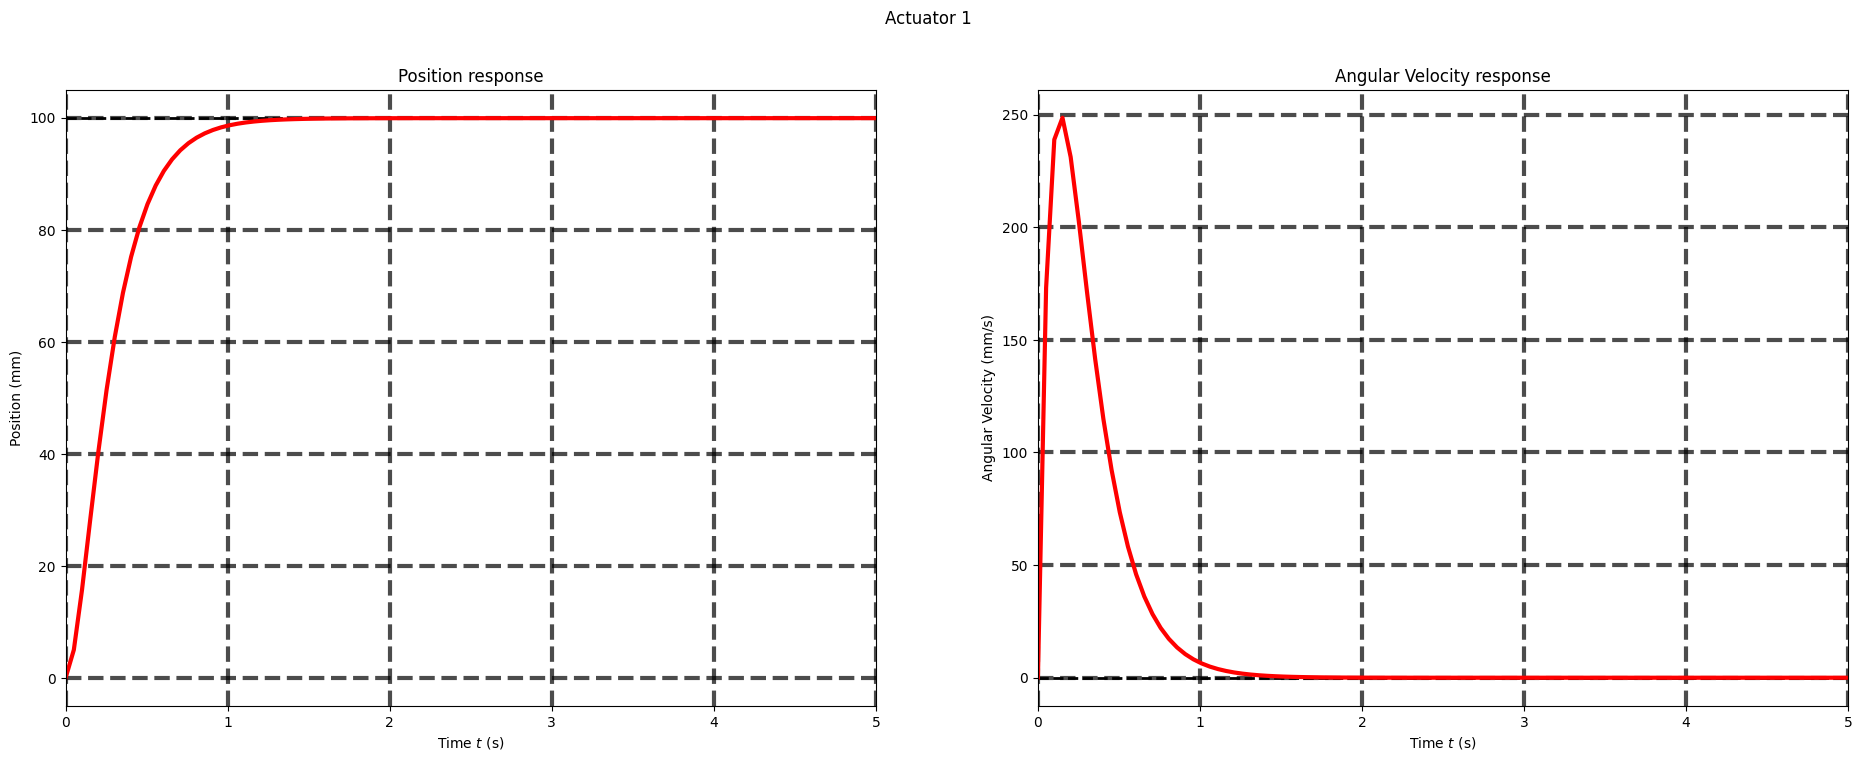

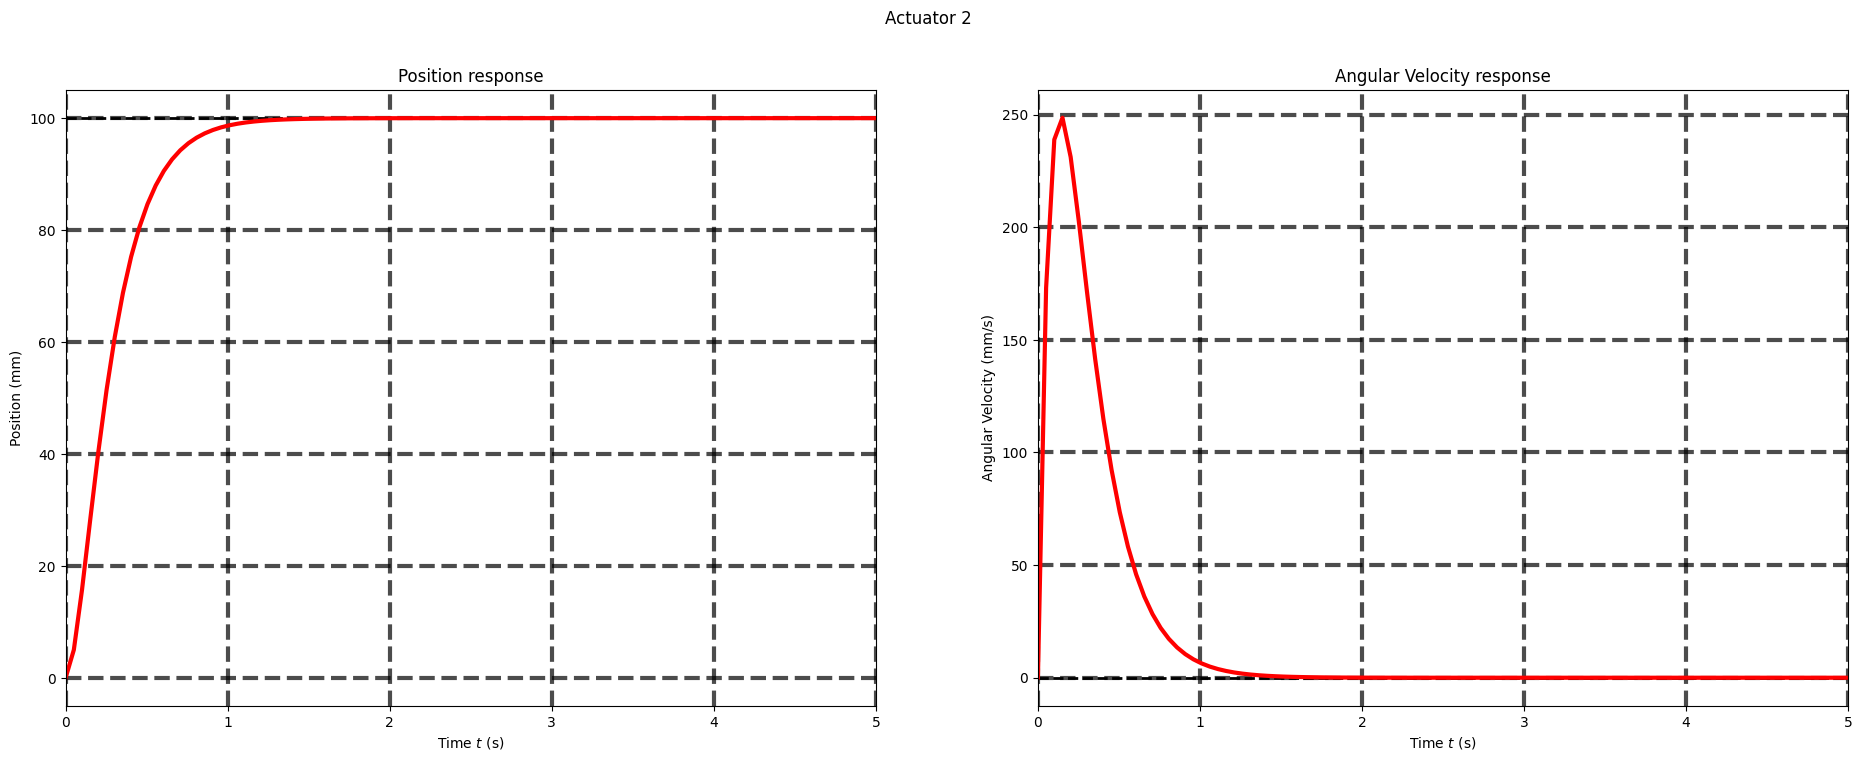

In [115]:
# Plot position

# Actuator 1 Plots
plt.figure(figsize=(23, 8))
plt.subplot(121)
plt.suptitle("Actuator 1")
plt.title(r'Position response')
plt.hlines(x_d[0], min(t), max(t), color = 'black', linestyles='--', linewidth=2.0)
plt.plot(t, x_1, 'r', linewidth=3.0)
plt.grid(color='black', linestyle='--', linewidth=3.0, alpha = 0.7)
plt.grid(True)
plt.xlim([0, tf])
plt.ylabel(r'Position (mm)')
plt.xlabel(r'Time $t$ (s)')

plt.subplot(122)
plt.title(r'Angular Velocity response')
plt.hlines(x_d[1], min(t), max(t), color = 'black', linestyles='--', linewidth=2.0)
plt.plot(t, dx_1, 'r', linewidth=3.0)
plt.grid(color='black', linestyle='--', linewidth=3.0, alpha = 0.7)
plt.grid(True)
plt.xlim([0, tf])
plt.ylabel(r'Angular Velocity (mm/s)')
plt.xlabel(r'Time $t$ (s)')
plt.show()

# Actuator 2 Plots
plt.figure(figsize=(23, 8))
plt.subplot(121)
plt.suptitle("Actuator 2")
plt.title(r'Position response')
plt.hlines(x_d[2], min(t), max(t), color = 'black', linestyles='--', linewidth=2.0)
plt.plot(t, x_2, 'r', linewidth=3.0)
plt.grid(color='black', linestyle='--', linewidth=3.0, alpha = 0.7)
plt.grid(True)
plt.xlim([0, tf])
plt.ylabel(r'Position (mm)')
plt.xlabel(r'Time $t$ (s)')

plt.subplot(122)
plt.title(r'Angular Velocity response')
plt.hlines(x_d[3], min(t), max(t), color = 'black', linestyles='--', linewidth=2.0)
plt.plot(t, dx_2, 'r', linewidth=3.0)
plt.grid(color='black', linestyle='--', linewidth=3.0, alpha = 0.7)
plt.grid(True)
plt.xlim([0, tf])
plt.ylabel(r'Angular Velocity (mm/s)')
plt.xlabel(r'Time $t$ (s)')
plt.show()


<hr>

## 8. Tension $T_e$ in the tape is maintained at 10 N

In [116]:
te = k*((x_2+x_1)/2 + 5/k - (x_1+x_2)/2 + 5/k)

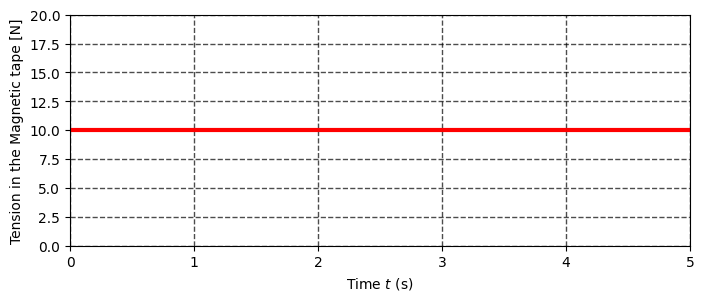

In [117]:
te_t = np.linspace(0, tf, N)

plt.figure(figsize=(8, 3))
plt.plot(t, te, 'r', linewidth=3.0)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.xlim([0, tf])
plt.ylim([0, 20])
plt.ylabel(r'Tension in the Magnetic tape [N]')
plt.xlabel(r'Time $t$ (s)')
plt.show()

<hr>

## 9. The distance is maintained such that $x_3=x_d=\frac{x_1+x_2}{2}$

In [118]:
x3 = (x_1 + x_2)/2

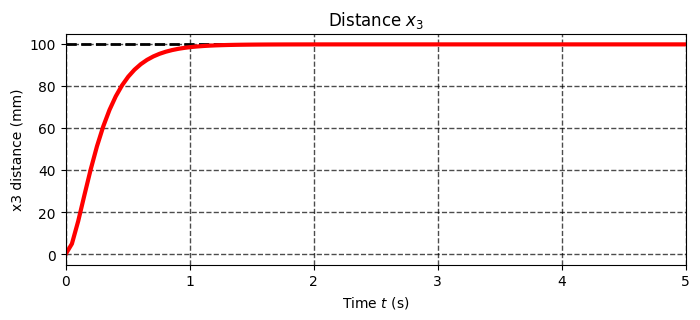

In [119]:
plt.figure(figsize=(8, 3))
plt.title(r"Distance $x_3$")
plt.hlines(x_d[0], min(t), max(t), color = 'black', linestyles='--', linewidth=2.0)
plt.plot(t, x3, 'r', linewidth=3.0)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.xlim([0, tf])
plt.ylabel(r'x3 distance (mm)')
plt.xlabel(r'Time $t$ (s)')
plt.show()

# Problem №2: Pole Placement Design of Linear Observers

<hr>

Consider the LTI system in state space form:

$$
\begin{gathered}
\dot{\mathbf{x}}=\mathbf{A x}+\mathbf{B u} \\
\mathbf{y}=\mathbf{C x}
\end{gathered}
$$

Where the last equation describe your actual measurements (output) as some linear combination of states $\mathbf{y}=\mathbf{C x}$. Goal is to estimate the full state $\hat{\mathbf{x}}$, based on known measurements $\mathbf{y}$ and control signal $\mathbf{u}$ assuming that $\mathbf{A}, \mathbf{B}, \mathbf{C}$ are known.

Consider the state observer algorithm is given as follows:

$$
\dot{\hat{\mathbf{x}}}=\mathbf{A} \hat{\mathbf{x}}+\mathbf{B u}+\mathbf{L}(\mathbf{y}-\hat{\mathbf{y}})
$$

Contents
1. Find the closed loop response of estimation error $\mathbf{e}=\hat{\mathbf{x}}-\mathbf{x}$ in terms of $\mathbf{A}, \mathbf{C}, \mathbf{L}, \mathbf{e}(t)$ (equations for $\dot{\mathrm{e}}$ ).
2. What are the conditions on $\mathbf{L}$ that implies the convergence of estimates $\hat{\mathbf{x}}$ to the actual state $\mathbf{x}$, describe how would you use pole placement routine to tune observer gains $\mathbf{L}$

<hr>

<hr>

## 1. Find the closed loop response of estimation error $\mathbf{e}=\hat{\mathbf{x}}-\mathbf{x}$ in terms of $\mathbf{A}, \mathbf{C}, \mathbf{L}, \mathbf{e}(t)$ (equations for $\dot{\mathrm{e}}$ ).

#### Solution:

We have the following equations:
$$
\dot{\hat{\mathbf{x}}}=\mathbf{A} \hat{\mathbf{x}}+\mathbf{B u}+\mathbf{L}(\mathbf{y}-\hat{\mathbf{y}})
$$

$$
\hat{\mathbf{y}} = \mathbf{C} \hat{\mathbf{x}}
$$

From above two equations we get the following:

$$
\dot{\hat{\mathbf{x}}}=(\mathbf{A}-\mathbf{L C})\hat{\mathbf{x}}+\mathbf{B u}+\mathbf{L y}
$$

Also we know that
$$
\begin{gathered}
\dot{\mathbf{x}}=\mathbf{A x}+\mathbf{B u} \\
\mathbf{y}=\mathbf{C x}
\end{gathered}
$$

And the error is give by the following equations:
$$\mathbf{e}=\hat{\mathbf{x}}-\mathbf{x}$$
$$\dot{\mathbf{e}}=\dot{\hat{\mathbf{x}}}-\dot{\mathbf{x}}$$

Substitute  $\dot{\hat{\mathbf{x}}}, \hspace{0.1cm} \dot{\mathbf{x}}\hspace{0.4cm} in\hspace{0.4cm} \dot{\mathbf{e}}$

We get the following:

$$
\dot{\mathbf{e}}= (\mathbf{A}-\mathbf{L C})(\hat{\mathbf{x}}-\mathbf{x})
$$

Which is finally expressed as :
$$
\dot{\mathbf{e}}= (\mathbf{A}-\mathbf{L C})\mathbf{e}
$$

We know that eigen values can be extracted from the following:

$$
|\lambda$\mathbf{I} - (\mathbf{A}-\mathbf{L C})| = 0 \hspace{0.5cm}is\hspace{0.5cm}same\hspace{0.5cm}as\hspace{0.5cm}|\lambda$\mathbf{I} - (\mathbf{A}-\mathbf{L C})^T| = 0
$$

The following are also the same

$$
|\lambda$\mathbf{I} - (\mathbf{A^T}-\mathbf{C^T L^T})| = 0 \hspace{0.5cm}\equiv\hspace{0.5cm} |\lambda$\mathbf{I} - (\mathbf{A}-\mathbf{B K})| = 0
$$

Therefore finally:
$$
\mathbf{C^T} \hspace{0.5cm}\equiv\hspace{0.5cm} \mathbf{B} \hspace{0.5cm}and\hspace{0.5cm} \mathbf{L^T} \hspace{0.5cm}\equiv\hspace{0.5cm} \mathbf{K}
$$

<hr>

## 2. What are the conditions on $\mathbf{L}$ that implies the convergence of estimates $\hat{\mathbf{x}}$ to the actual state $\mathbf{x}$, describe how would you use pole placement routine to tune observer gains $\mathbf{L}$

#### Answer:
I see there are two conditions for estimated state $\hat{\mathbf{x}}$ converging to the actual state $\mathbf{x}$:

1. The poles of the matrix $(\mathbf{A^T}-\mathbf{C^T L^T})$ should be in the negative half of the complex plane.
2. The poles of the observer can be placed if and only if the system has a full rank or if the system is fully controllable.

This can be verified by using ${place\_poles()}$ method from the ${scipy.signal}$ library.

The simple example code to demonstrate this can be written as follows

In [120]:
# For example
A = np.array([[0, 1],
              [-1, 0.1]])

B = np.array([[0],
              [0]])

C = np.array([[1, 0]])
print(A.shape)
print(C.shape)

(2, 2)
(1, 2)


In [121]:
P = np.array([-0.5-0j, -0.6+0j])    # New poles, tested to be close to the desired values
L_T = place_poles(np.transpose(A), np.transpose(C), P).gain_matrix        # New Gain Matrix L transpose according to the new Poles
Ae = np.transpose(A) - np.transpose(C)@L_T                                # New Ae matrix with new Poles
eig_vals, q = np.linalg.eig(Ae)             # Eigen values of Ae Matrix
print("Eigen Values of Ae matrix : ", real(eig_vals), end="\n\n")
print("Gain-matrix L : \n", L_T, end="\n\n")
print("Shape of L matrix : ", L_T.shape, end="\n\n")

Eigen Values of Ae matrix :  [-0.6 -0.5]

Gain-matrix L : 
 [[ 1.2  -0.58]]

Shape of L matrix :  (1, 2)



# BONUS Task

<hr>

1. Implement the proposed observer in order to estimate the motor states $\theta_{j}, \dot{\theta}_{j}$ of magnetic tape system given the measurements of $x_{3}$ and $T_{e}$ and use these estimate for the feedback instead of $\mathbf{x},(\mathbf{u}=-\mathbf{K} \hat{\mathbf{x}})$

<hr>

In [122]:
temp1 = (k*(r**2)/J)
temp2 = (b*(r**2)/J)

A = np.array([[0, 1, 0, 0],
              [temp1, temp2, -temp1, -temp2],
              [0, 0, 0, 1],
              [temp1, temp2, -temp1, -temp2]])

B = np.array([[0, 0],
              [r*Km/J, 0],
              [0, 0],
              [0, r*Km/J]])

C = np.array([[0, 1, 0, 1]])

In [123]:
check_stability(A)

Eigen values of matrix are :  [-0.00269385 -0.00269385  0.00269385  0.00269385]
System is unstable


In [124]:
eigs, ranks, test = pbh_with_stability(np.transpose(A), np.transpose(C))
print(f'Eigen values of A matrix:\n{eigs}\n\nRanks of the PBH matrices: {ranks},\nsystem is {test}' )

Eigen values of A matrix:
[-3.55299440e-03+0.j          3.55305503e-03+0.j
 -3.03133129e-08+0.00355302j -3.03133129e-08-0.00355302j]

Ranks of the PBH matrices: [4, 4, 4, 4],
system is controllable


In [125]:
P = np.array([-60.0+0j, -50.0+0j, -70.0-0j, -80.0-0j])    # New poles, tested to be close to the desired values
L_T = place_poles(np.transpose(A), np.transpose(C), P).gain_matrix        # New Gain Matrix L transpose according to the new Poles
Ae = np.transpose(A) - np.transpose(C)@L_T                                # New Ae matrix with new Poles
eig_vals, q = np.linalg.eig(Ae)             # Eigen values of Ae Matrix
print("Eigen Values of Ae matrix : ", real(eig_vals), end="\n\n")
print("Gain-matrix L_T : \n", L_T, end="\n\n")
print("Shape of L_T matrix : ", L_T.shape, end="\n\n")

Eigen Values of Ae matrix :  [-8.99008932e+01 -6.17482159e+01 -5.51308059e+01 -1.55929135e-09]

Gain-matrix L_T : 
 [[1.39661447e+13 1.95756375e+02 1.39661447e+13 1.10235403e+01]]

Shape of L_T matrix :  (1, 4)



In [126]:
check_stability(Ae)

Eigen values of matrix are :  [-8.99008932e+01 -6.17482159e+01 -5.51308059e+01 -1.55929135e-09]
System is stable


In [127]:
L = np.transpose(L_T)

In [128]:
np.transpose(L)

array([[1.39661447e+13, 1.95756375e+02, 1.39661447e+13, 1.10235403e+01]])